# MCMC

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads
from numpyro.infer import MCMC, NUTS, AIES
import arviz as az

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')


import jax.numpy as jnp
import jax
from jax import jit
import pandas as pd
from tqdm import tqdm

code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(42)
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)

params_sim = params


# ----------------------------- Load observation & precompute target densities ----------------
true_GD1_observation_path = '/export/data/vgiusepp/odisseo_data/data_fix_position/true.npz'
_obs = np.load(true_GD1_observation_path)
stream_data = jnp.array(_obs['x']).reshape(1000, 6)  # will be used only to compute target densities
true_theta = jnp.array(_obs['theta'])

stream_data = stream_data[(stream_data[:, 1] > -100) & (stream_data[:, 1] < 25)]  # Filter data within phi1 range
@jit
def run_simulation(params):

    Mvir, M_MN, r_s, a, b, = params
    Mvir = params['M_NFW']
    M_MN = params['M_MN']
    r_s = params['r_s']
    a = params['a_MN']
    b = params['b_MN']

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    return stream_coordinate_com


@jit
def stream_loglikelihood(stream_coordinate_com, ):
    phi1_min, phi1_max = -150, 60
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])
    
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    mask_backward = mask_window_backward & mask_diff_backward
    mask_forward = mask_window_forward & mask_diff_forward



    def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

    def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

    phi1_backward_valid, coord_backward_valid = jax.vmap(lambda coordinate: coord_backward_fill(stream_coordinate_com_backward[:, 0, 1], stream_coordinate_com_backward[:, 0, coordinate], mask_backward))(coordinate=coord_indices)
    phi1_forward_valid, coord_forw_valid = jax.vmap(lambda coordinate: coord_forward_fill(stream_coordinate_com_forward[:, 0, 1], stream_coordinate_com_forward[:, 0, coordinate], mask_forward))(coordinate=coord_indices)


    def interpolate_coord_backward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_backward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_backward_valid[0], coord)
    
    def interpolate_coord_forward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_forward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_forward_valid[0][::-1], coord[::-1])
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_backward_valid)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_forw_valid)  # Shape: (n_coords, n_data)


    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 0.05, 0.2 ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    mask_correct_interpolation_backward = stream_data[:, 1] <= 60
    mask_correct_interpolation_forward = stream_data[:, 1] >= - 150

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    residuals = jnp.where(mask_stream_backward,
                         residuals_backward,
                         residuals_forward)

    chi2 = jnp.sum(residuals**2)
    
    return -0.5 * chi2 

    
    
@jit
def evaluate_loglikelihood(theta_1, ):

        # print(f"In the corrector: theta_1 shape: {theta_1.shape}, target shape: {target.shape}")
        output = run_simulation(theta_1)

        # return stream_likelihood(model_stream=output, obs_stream=observation, obs_errors=jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001]))
        return stream_loglikelihood(stream_coordinate_com=output, )


In [ ]:
# # --- keep your existing imports; add these ---
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.initialization import init_to_value, init_to_median
from numpyro.handlers import reparam
from jax import random

# --- ASSUMPTION: run_simulation(params_dict) returns the stream coordinates for given params
# --- and stream_loglikelihood(stream_coordinate_com) returns the log-likelihood (float)

# Wrap run_simulation and stream_loglikelihood in jitted functions (you already have @jit in your code).
# Here we assume run_simulation expects a dict with keys 'M_NFW','r_s','M_MN','a_MN' (floats).

num_walkers = 10
num_warmup  = 250
num_samples = 1000

# --- NUMPYRO MODEL ---
def numpyro_stream_model():


    M_NFW = numpyro.sample("M_NFW", dist.Uniform(4.3683325e11 * 0.25, 4.3683325e11 * 2.0))
    M_MN  = numpyro.sample("M_MN",  dist.Uniform(68_193_902_782.346756 * 0.25, 68_193_902_782.346756 * 2.0))  # (example)
    r_s   = numpyro.sample("r_s",   dist.Uniform(16.0 * 0.5, 16.0*2))  # (example)
    a_MN  = numpyro.sample("a_MN",  dist.Uniform(3 * 0.5, 3.0 * 2))  # (example)
    b_MN  = numpyro.sample("b_MN",  dist.Uniform(0.280 * 0.5, 0.280 * 2))  # (example)

    params_dict = {
        "M_NFW": M_NFW,
        "r_s": r_s,
        "M_MN": M_MN,
        "a_MN": a_MN,
        "b_MN": b_MN,
    }

    # Run your (jitted) simulator and log-likelihood.
    # IMPORTANT: both functions are JAX-jittable and side-effect free (no Python side-effects).
    stream_coord = run_simulation(params_dict)   # returns shape (2, n_snapshots, ncols) as before
    log_like = stream_loglikelihood(stream_coord)  # scalar float (JAX array)

    # Register the likelihood with NumPyro
    # numpyro.factor adds an arbitrary log-probability term to the joint.
    numpyro.factor("sim_loglik", log_like)

    # Optionally you can add priors or other observations
    # e.g., if you had observed quantities you could do:
    # numpyro.sample("obs", dist.Normal(model_mean, sigma), obs=observations)

# --- RUN NUTS / MCMC ---
rng_key = random.PRNGKey(42)

# NUTS kernel: try dense_mass=True for complex geometry; set target_accept higher if needed
kernel = NUTS(numpyro_stream_model,)  # try True if needed
mcmc = MCMC(kernel, num_warmup=num_warmup,
            num_samples=num_samples, num_chains=num_walkers,
            chain_method='vectorized')

# (Optional) choose a good init strategy:
# - init_to_median() is a reasonable generic choice if the prior is informative
# - init_to_value({'log_M_NFW': jnp.log(4.368e11), ...}) can be used to start near truth
# for demonstration we run with default init; you can pass init_strategy to NUTS()
mcmc.run(rng_key)
mcmc.print_summary(exclude_deterministic=False)  # include deterministic fields (M_NFW, r_s, ...)

#saving
# numpyro_data = az.from_numpyro(mcmc)
# numpyro_data.to_json('./aies')

warmup:   1%|          | 10/1250 [37:23<158:37:25, 460.52s/it]

In [ ]:
# from numpyro.infer import AIES
# num_walkers = 10
# num_warmup  = 10
# num_samples = 50

# master_key = jax.random.PRNGKey(42)
# walker_keys = jax.random.split(master_key, num_walkers)
# init_positions = jax.vmap(draw_from_prior)(walker_keys)

# kernel = AIES(potential_fn=potential_fn,
#               moves={AIES.StretchMove() : 1.2})

# mcmc = MCMC(kernel, num_warmup=num_warmup,
#             num_samples=num_samples, num_chains=num_walkers,
#             chain_method='vectorized')

# mcmc.run(master_key, init_params=init_positions)
# samples = mcmc.get_samples(group_by_chain=True)


sample: 100%|██████████| 60/60 [03:15<00:00,  3.25s/it, acc. prob=0.28]


In [ ]:
import arviz as az
numpyro_data = az.from_numpyro(mcmc)
numpyro_data

In [ ]:
numpyro_data.to_json('./aies')

'./aies'

In [ ]:
numpyro_data = az.from_json('./aies')

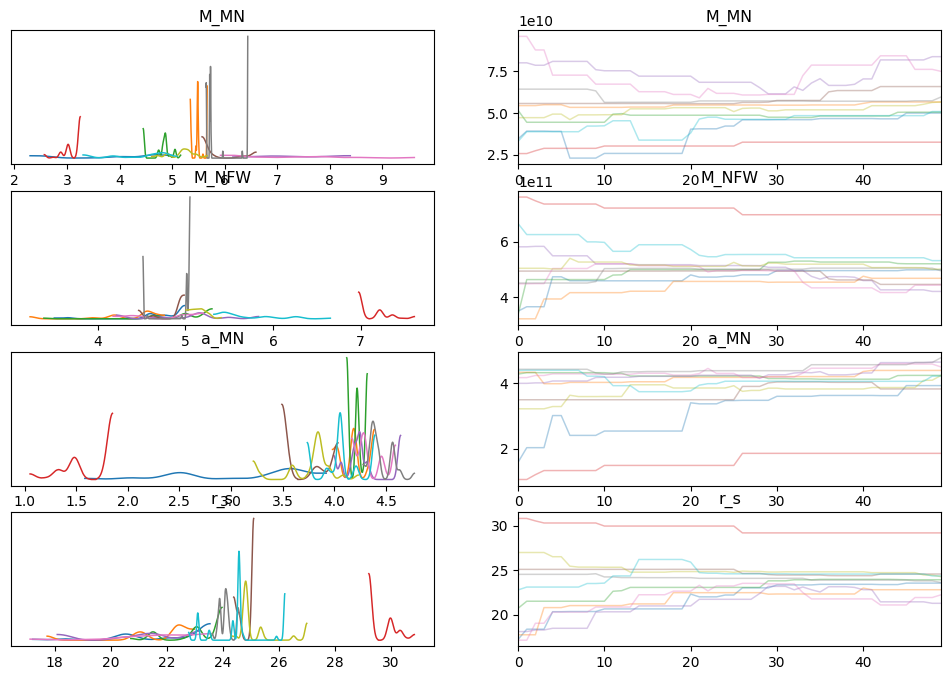

In [ ]:
az.plot_trace(numpyro_data, compact=False);

array([[<Axes: ylabel='M_NFW'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='a_MN'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='M_MN', ylabel='r_s'>, <Axes: xlabel='M_NFW'>,
        <Axes: xlabel='a_MN'>]], dtype=object)

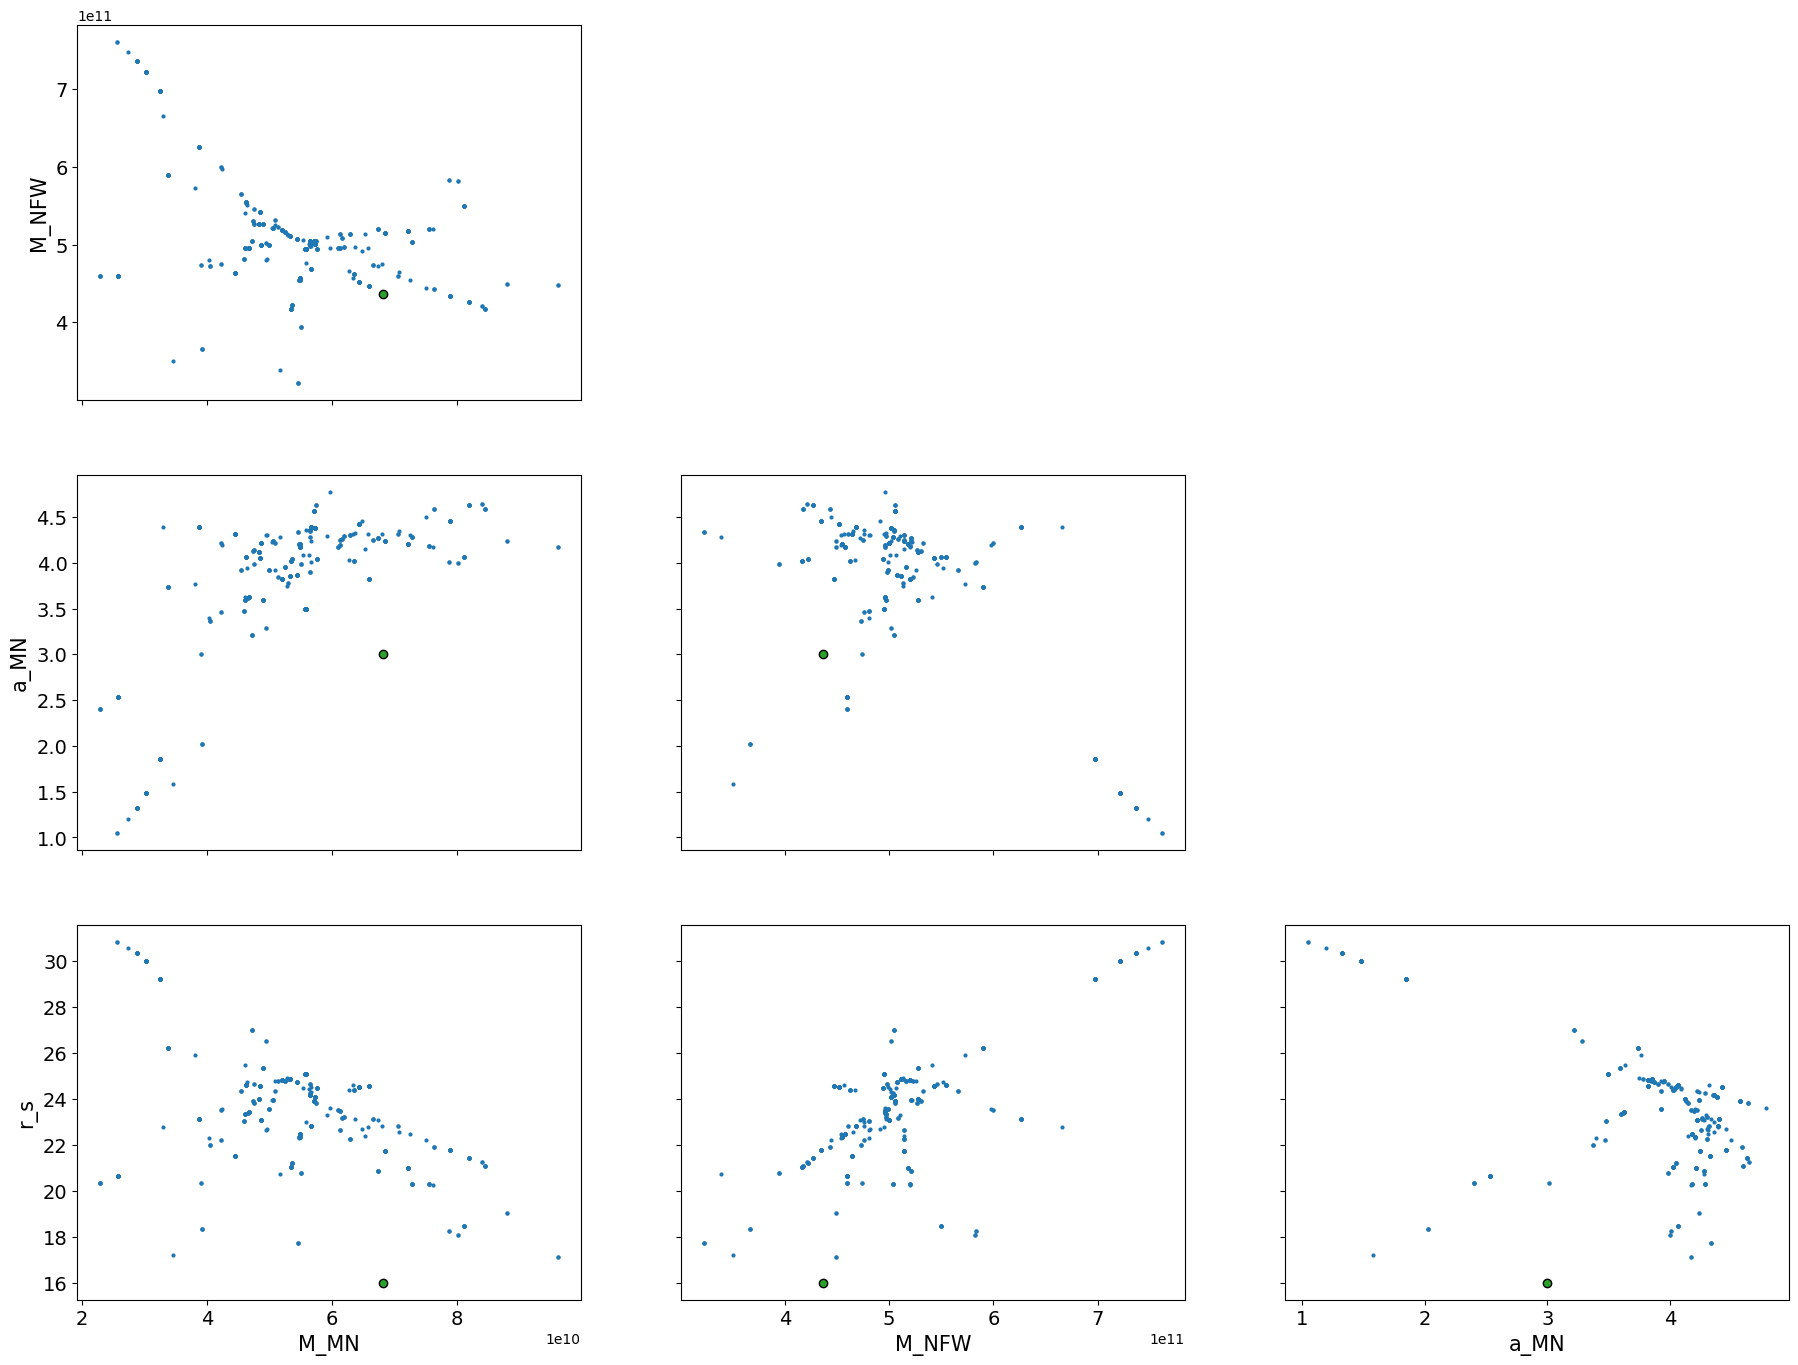

In [ ]:
true_params = jnp.array([4.3683325e11, 16.0, 68_193_902_782.346756, 3.0])  # M_NFW, r_s, M_MN, a_MN
true_params_dict = {'M_NFW': true_params[0], 'r_s': true_params[1], 'M_MN': true_params[2], 'a_MN': true_params[3]}
az.plot_pair(numpyro_data,
             reference_values=true_params_dict,)